In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

from tqdm import tqdm

from mcp_us_airline.utils import airport_utils
from mcp_us_airline.utils import constants
from mcp_us_airline.utils import demand_utils
from mcp_us_airline.utils import io_utils
from mcp_us_airline.utils import population_utils
from mcp_us_airline.utils import preprocess_utils

/tmp/ipykernel_1059797/1599647510.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

In [3]:
delta_min = 30  # minimum connect time w.o. sharing (unit: minute)
delta_share_min = 60  # minimum connect time w. sharing (unit: minute)
share = False  # flight share/non-share

YEAR = 2023
MONTH = 4
DATE = [18]
CARRIER = "all"

ontime_df = preprocess_utils.prepare_ontime_df(year=YEAR, 
                                               month=MONTH, 
                                               date=DATE, 
                                               carrier=CARRIER, 
                                               distance_function="geodesic",
                                               arrival_time="elapsed_time",
                                               contiguous_us=True)

ontime_df

/home/mk139/WorkSpace/minimum-cost-percolation-us-airline/libs/mcp_us_airline/mcp_us_airline/utils/preprocess_utils.py:68: DtypeWarning: Columns (11,13,86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  ontime_df = pd.read_csv(os.path.join(ONTIME_DIR, f"On_Time_Marketing_Carrier_{year}_{month}.csv"))


total number of flights in 2023-4: 596676

total number of flights opereated by all on 2023-4-[18]: 19458



100%|██████████| 19458/19458 [00:09<00:00, 2027.92it/s]


total number of flights after adding time/distance information: 19458



/home/mk139/WorkSpace/minimum-cost-percolation-us-airline/libs/mcp_us_airline/mcp_us_airline/utils/preprocess_utils.py:44: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv(f'{AIRCRAFT_DIR}/master_{year}.txt', sep=',')


number of flights with nan values: 98

number of nan values from missing tail number: 8



,flight_idx,Origin,Dest,Operating_Airline,Tail_Number,CRSDepTime,CRSArrTime,CRSElapsedTime,UTCDepTime,UTCArrTime,Distance,NO_SEATS
0,1,DCA,SEA,AS,N590AS,2023-04-18 08:00:00,2023-04-18 10:49:00,349.0,1.681819e+09,1.681840e+09,3747.303757,149.0
1,2,SEA,DCA,AS,N568AS,2023-04-18 14:00:00,2023-04-18 21:59:00,299.0,1.681852e+09,1.681870e+09,3747.303757,149.0
2,3,DCA,SEA,AS,N508AS,2023-04-18 17:35:00,2023-04-18 20:24:00,349.0,1.681854e+09,1.681875e+09,3747.303757,149.0
3,4,SEA,DCA,AS,N508AS,2023-04-18 08:25:00,2023-04-18 16:34:00,309.0,1.681832e+09,1.681850e+09,3747.303757,149.0
4,5,DCA,LAX,AS,N520AS,2023-04-18 09:10:00,2023-04-18 11:52:00,342.0,1.681823e+09,1.681844e+09,3719.085326,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18593,18594,BDL,CLT,OH,N567NN,2023-04-18 10:10:00,2023-04-18 12:16:00,126.0,1.681827e+09,1.681835e+09,1035.989568,95.0
18594,18595,CLT,BTR,OH,N607NN,2023-04-18 18:20:00,2023-04-18 19:36:00,136.0,1.681856e+09,1.681865e+09,1086.280033,95.0
18595,18596,DCA,CVG,OH,N582NN,2023-04-18 20:23:00,2023-04-18 22:14:00,111.0,1.681864e+09,1.681870e+09,661.595377,95.0
18596,18597,HPN,DCA,OH,N523AE,2023-04-18 06:30:00,2023-04-18 07:48:00,78.0,1.681814e+09,1.681818e+09,376.034307,80.0


In [11]:
delta_vals = np.linspace(0, 1200, 41)
delta_vals

configs = {1: {'share': False, 'epsilon': 30},  # here, epsilon is useless
           2: {'share': True, 'epsilon': 0},
           3: {'share': True, 'epsilon': 30},
           4: {'share': True, 'epsilon': 60},
           5: {'share': True, 'epsilon': 90},}


connection_counts = {1: [], 2: [], 3: [], 4: [], 5: []}
multi_carrier_connection_fractions = {1: [], 2: [], 3: [], 4: [], 5: []}


flights, origin_airport, destination_airport = preprocess_utils.group_flights_origin_destination(ontime_df)

for config_id, config in configs.items():
    print(f"working on config {config_id}")
    share = config['share']
    epsilon = config['epsilon']
    

    for delta in delta_vals:
        print(f"working on delta={delta}")
        connection_count = 0
        multi_carrier_connection_count = 0

        fcn = preprocess_utils.create_flight_connection_network(flights, origin_airport, delta, delta+epsilon, share)

        # count the number of connections
        for first_flight, second_flights in fcn.items():
            connection_count += len(second_flights)

            for second_flight in second_flights:
                carrier1 = flights[first_flight]["carrier"]
                carrier2 = flights[second_flight]["carrier"]
                if carrier1 != carrier2:
                    multi_carrier_connection_count += 1

        connection_counts[config_id].append(connection_count)
        if connection_count > 0:
            multi_carrier_connection_fractions[config_id].append(multi_carrier_connection_count / connection_count)
        else:
            multi_carrier_connection_fractions[config_id].append(0.)


# fcn

  0%|          | 0/18598 [00:00<?, ?it/s]

100%|██████████| 18598/18598 [00:00<00:00, 66609.80it/s]


working on config 1
working on delta=0.0


100%|██████████| 18598/18598 [00:03<00:00, 5404.32it/s]


# of total edges in FCN : 856225
working on delta=30.0


100%|██████████| 18598/18598 [00:03<00:00, 5315.71it/s]


# of total edges in FCN : 816432
working on delta=60.0


100%|██████████| 18598/18598 [00:03<00:00, 5362.83it/s]


# of total edges in FCN : 756194
working on delta=90.0


100%|██████████| 18598/18598 [00:03<00:00, 5462.37it/s]


# of total edges in FCN : 691107
working on delta=120.0


100%|██████████| 18598/18598 [00:03<00:00, 5435.62it/s]


# of total edges in FCN : 645403
working on delta=150.0


100%|██████████| 18598/18598 [00:03<00:00, 5476.97it/s]


# of total edges in FCN : 606196
working on delta=180.0


100%|██████████| 18598/18598 [00:03<00:00, 5160.24it/s]


# of total edges in FCN : 561201
working on delta=210.0


100%|██████████| 18598/18598 [00:03<00:00, 5406.15it/s]


# of total edges in FCN : 516999
working on delta=240.0


100%|██████████| 18598/18598 [00:03<00:00, 5428.09it/s]


# of total edges in FCN : 480627
working on delta=270.0


100%|██████████| 18598/18598 [00:03<00:00, 5474.82it/s]


# of total edges in FCN : 446446
working on delta=300.0


100%|██████████| 18598/18598 [00:03<00:00, 5465.15it/s]


# of total edges in FCN : 410023
working on delta=330.0


100%|██████████| 18598/18598 [00:03<00:00, 5477.18it/s]


# of total edges in FCN : 375293
working on delta=360.0


100%|██████████| 18598/18598 [00:03<00:00, 5251.30it/s]


# of total edges in FCN : 343320
working on delta=390.0


100%|██████████| 18598/18598 [00:03<00:00, 5674.03it/s]


# of total edges in FCN : 312564
working on delta=420.0


100%|██████████| 18598/18598 [00:03<00:00, 5594.11it/s]


# of total edges in FCN : 281700
working on delta=450.0


100%|██████████| 18598/18598 [00:03<00:00, 5550.61it/s]


# of total edges in FCN : 251715
working on delta=480.0


100%|██████████| 18598/18598 [00:03<00:00, 5537.03it/s]


# of total edges in FCN : 224725
working on delta=510.0


100%|██████████| 18598/18598 [00:03<00:00, 5549.91it/s]


# of total edges in FCN : 199154
working on delta=540.0


100%|██████████| 18598/18598 [00:03<00:00, 5565.28it/s]


# of total edges in FCN : 174862
working on delta=570.0


100%|██████████| 18598/18598 [00:03<00:00, 5307.74it/s]


# of total edges in FCN : 152225
working on delta=600.0


100%|██████████| 18598/18598 [00:03<00:00, 5588.59it/s]


# of total edges in FCN : 131813
working on delta=630.0


100%|██████████| 18598/18598 [00:03<00:00, 5661.90it/s]


# of total edges in FCN : 112073
working on delta=660.0


100%|██████████| 18598/18598 [00:03<00:00, 5665.49it/s]


# of total edges in FCN : 93314
working on delta=690.0


100%|██████████| 18598/18598 [00:03<00:00, 5755.59it/s]


# of total edges in FCN : 77414
working on delta=720.0


100%|██████████| 18598/18598 [00:03<00:00, 5766.24it/s]


# of total edges in FCN : 61882
working on delta=750.0


100%|██████████| 18598/18598 [00:03<00:00, 5424.18it/s]


# of total edges in FCN : 47910
working on delta=780.0


100%|██████████| 18598/18598 [00:03<00:00, 5689.83it/s]


# of total edges in FCN : 36712
working on delta=810.0


100%|██████████| 18598/18598 [00:03<00:00, 5783.91it/s]


# of total edges in FCN : 27031
working on delta=840.0


100%|██████████| 18598/18598 [00:03<00:00, 5782.97it/s]


# of total edges in FCN : 17939
working on delta=870.0


100%|██████████| 18598/18598 [00:03<00:00, 5785.57it/s]


# of total edges in FCN : 10993
working on delta=900.0


100%|██████████| 18598/18598 [00:03<00:00, 5793.37it/s]


# of total edges in FCN : 6216
working on delta=930.0


100%|██████████| 18598/18598 [00:03<00:00, 5786.96it/s]


# of total edges in FCN : 2693
working on delta=960.0


100%|██████████| 18598/18598 [00:03<00:00, 5536.70it/s]


# of total edges in FCN : 980
working on delta=990.0


100%|██████████| 18598/18598 [00:03<00:00, 5789.83it/s]


# of total edges in FCN : 271
working on delta=1020.0


100%|██████████| 18598/18598 [00:03<00:00, 5785.60it/s]


# of total edges in FCN : 86
working on delta=1050.0


100%|██████████| 18598/18598 [00:03<00:00, 5790.03it/s]


# of total edges in FCN : 15
working on delta=1080.0


100%|██████████| 18598/18598 [00:03<00:00, 5781.07it/s]


# of total edges in FCN : 3
working on delta=1110.0


100%|██████████| 18598/18598 [00:03<00:00, 5783.19it/s]


# of total edges in FCN : 0
working on delta=1140.0


100%|██████████| 18598/18598 [00:03<00:00, 5525.83it/s]


# of total edges in FCN : 0
working on delta=1170.0


100%|██████████| 18598/18598 [00:03<00:00, 5785.83it/s]


# of total edges in FCN : 0
working on delta=1200.0


100%|██████████| 18598/18598 [00:03<00:00, 5783.68it/s]


# of total edges in FCN : 0
working on config 2
working on delta=0.0


100%|██████████| 18598/18598 [00:04<00:00, 4614.32it/s]


# of total edges in FCN : 2861768
working on delta=30.0


100%|██████████| 18598/18598 [00:04<00:00, 4534.54it/s]


# of total edges in FCN : 2707592
working on delta=60.0


100%|██████████| 18598/18598 [00:04<00:00, 4622.88it/s]


# of total edges in FCN : 2515389
working on delta=90.0


100%|██████████| 18598/18598 [00:03<00:00, 4716.55it/s]


# of total edges in FCN : 2313846
working on delta=120.0


100%|██████████| 18598/18598 [00:04<00:00, 4462.90it/s]


# of total edges in FCN : 2153294
working on delta=150.0


100%|██████████| 18598/18598 [00:03<00:00, 4788.88it/s]


# of total edges in FCN : 2008354
working on delta=180.0


100%|██████████| 18598/18598 [00:03<00:00, 4805.34it/s]


# of total edges in FCN : 1854536
working on delta=210.0


100%|██████████| 18598/18598 [00:03<00:00, 4857.85it/s]


# of total edges in FCN : 1705223
working on delta=240.0


100%|██████████| 18598/18598 [00:03<00:00, 4857.80it/s]


# of total edges in FCN : 1575431
working on delta=270.0


100%|██████████| 18598/18598 [00:03<00:00, 4931.98it/s]


# of total edges in FCN : 1453469
working on delta=300.0


100%|██████████| 18598/18598 [00:03<00:00, 4667.54it/s]


# of total edges in FCN : 1328549
working on delta=330.0


100%|██████████| 18598/18598 [00:03<00:00, 4972.64it/s]


# of total edges in FCN : 1208324
working on delta=360.0


100%|██████████| 18598/18598 [00:03<00:00, 5000.19it/s]


# of total edges in FCN : 1096623
working on delta=390.0


100%|██████████| 18598/18598 [00:03<00:00, 5017.75it/s]


# of total edges in FCN : 988444
working on delta=420.0


100%|██████████| 18598/18598 [00:03<00:00, 5067.26it/s]


# of total edges in FCN : 884811
working on delta=450.0


100%|██████████| 18598/18598 [00:03<00:00, 5044.10it/s]


# of total edges in FCN : 786696
working on delta=480.0


100%|██████████| 18598/18598 [00:03<00:00, 5114.33it/s]


# of total edges in FCN : 697507
working on delta=510.0


100%|██████████| 18598/18598 [00:03<00:00, 4902.29it/s]


# of total edges in FCN : 613136
working on delta=540.0


100%|██████████| 18598/18598 [00:03<00:00, 5165.25it/s]


# of total edges in FCN : 535625
working on delta=570.0


100%|██████████| 18598/18598 [00:03<00:00, 5184.34it/s]


# of total edges in FCN : 463146
working on delta=600.0


100%|██████████| 18598/18598 [00:03<00:00, 5200.30it/s]


# of total edges in FCN : 396389
working on delta=630.0


100%|██████████| 18598/18598 [00:03<00:00, 5209.70it/s]


# of total edges in FCN : 332966
working on delta=660.0


100%|██████████| 18598/18598 [00:03<00:00, 5238.39it/s]


# of total edges in FCN : 274379
working on delta=690.0


100%|██████████| 18598/18598 [00:03<00:00, 5018.41it/s]


# of total edges in FCN : 222958
working on delta=720.0


100%|██████████| 18598/18598 [00:03<00:00, 5273.57it/s]


# of total edges in FCN : 173888
working on delta=750.0


100%|██████████| 18598/18598 [00:03<00:00, 5290.10it/s]


# of total edges in FCN : 131101
working on delta=780.0


100%|██████████| 18598/18598 [00:03<00:00, 5302.68it/s]


# of total edges in FCN : 96902
working on delta=810.0


100%|██████████| 18598/18598 [00:03<00:00, 5309.28it/s]


# of total edges in FCN : 68955
working on delta=840.0


100%|██████████| 18598/18598 [00:03<00:00, 5313.69it/s]


# of total edges in FCN : 44852
working on delta=870.0


100%|██████████| 18598/18598 [00:03<00:00, 5325.88it/s]


# of total edges in FCN : 27572
working on delta=900.0


100%|██████████| 18598/18598 [00:03<00:00, 5109.55it/s]


# of total edges in FCN : 16125
working on delta=930.0


100%|██████████| 18598/18598 [00:03<00:00, 5328.77it/s]


# of total edges in FCN : 7807
working on delta=960.0


100%|██████████| 18598/18598 [00:03<00:00, 5330.19it/s]


# of total edges in FCN : 3768
working on delta=990.0


100%|██████████| 18598/18598 [00:03<00:00, 5332.52it/s]


# of total edges in FCN : 1625
working on delta=1020.0


100%|██████████| 18598/18598 [00:03<00:00, 5332.51it/s]


# of total edges in FCN : 620
working on delta=1050.0


100%|██████████| 18598/18598 [00:03<00:00, 5333.14it/s]


# of total edges in FCN : 128
working on delta=1080.0


100%|██████████| 18598/18598 [00:03<00:00, 5085.86it/s]


# of total edges in FCN : 14
working on delta=1110.0


100%|██████████| 18598/18598 [00:03<00:00, 5309.61it/s]


# of total edges in FCN : 1
working on delta=1140.0


100%|██████████| 18598/18598 [00:03<00:00, 5335.45it/s]


# of total edges in FCN : 0
working on delta=1170.0


100%|██████████| 18598/18598 [00:03<00:00, 5335.02it/s]


# of total edges in FCN : 0
working on delta=1200.0


100%|██████████| 18598/18598 [00:03<00:00, 5339.37it/s]


# of total edges in FCN : 0
working on config 3
working on delta=0.0


100%|██████████| 18598/18598 [00:03<00:00, 4654.75it/s]


# of total edges in FCN : 2747385
working on delta=30.0


100%|██████████| 18598/18598 [00:04<00:00, 4597.51it/s]


# of total edges in FCN : 2575627
working on delta=60.0


100%|██████████| 18598/18598 [00:04<00:00, 4431.13it/s]


# of total edges in FCN : 2378933
working on delta=90.0


100%|██████████| 18598/18598 [00:03<00:00, 4750.47it/s]


# of total edges in FCN : 2198998
working on delta=120.0


100%|██████████| 18598/18598 [00:03<00:00, 4786.79it/s]


# of total edges in FCN : 2047561
working on delta=150.0


100%|██████████| 18598/18598 [00:03<00:00, 4777.31it/s]


# of total edges in FCN : 1899531
working on delta=180.0


100%|██████████| 18598/18598 [00:03<00:00, 4819.21it/s]


# of total edges in FCN : 1749425
working on delta=210.0


100%|██████████| 18598/18598 [00:03<00:00, 4888.61it/s]


# of total edges in FCN : 1611803
working on delta=240.0


100%|██████████| 18598/18598 [00:04<00:00, 4638.90it/s]


# of total edges in FCN : 1487650
working on delta=270.0


100%|██████████| 18598/18598 [00:03<00:00, 4955.88it/s]


# of total edges in FCN : 1364972
working on delta=300.0


100%|██████████| 18598/18598 [00:03<00:00, 4970.73it/s]


# of total edges in FCN : 1243054
working on delta=330.0


100%|██████████| 18598/18598 [00:03<00:00, 4972.85it/s]


# of total edges in FCN : 1128596
working on delta=360.0


100%|██████████| 18598/18598 [00:03<00:00, 5027.34it/s]


# of total edges in FCN : 1019200
working on delta=390.0


100%|██████████| 18598/18598 [00:03<00:00, 5041.95it/s]


# of total edges in FCN : 915675
working on delta=420.0


100%|██████████| 18598/18598 [00:03<00:00, 5092.49it/s]


# of total edges in FCN : 816681
working on delta=450.0


100%|██████████| 18598/18598 [00:03<00:00, 4877.39it/s]


# of total edges in FCN : 724497
working on delta=480.0


100%|██████████| 18598/18598 [00:03<00:00, 5146.32it/s]


# of total edges in FCN : 638707
working on delta=510.0


100%|██████████| 18598/18598 [00:03<00:00, 5157.35it/s]


# of total edges in FCN : 559917
working on delta=540.0


100%|██████████| 18598/18598 [00:03<00:00, 5175.09it/s]


# of total edges in FCN : 485783
working on delta=570.0


100%|██████████| 18598/18598 [00:03<00:00, 5189.23it/s]


# of total edges in FCN : 416801
working on delta=600.0


100%|██████████| 18598/18598 [00:03<00:00, 5221.00it/s]


# of total edges in FCN : 352706
working on delta=630.0


100%|██████████| 18598/18598 [00:03<00:00, 5001.56it/s]


# of total edges in FCN : 293138
working on delta=660.0


100%|██████████| 18598/18598 [00:03<00:00, 5258.85it/s]


# of total edges in FCN : 238858
working on delta=690.0


100%|██████████| 18598/18598 [00:03<00:00, 5272.11it/s]


# of total edges in FCN : 189420
working on delta=720.0


100%|██████████| 18598/18598 [00:03<00:00, 5288.19it/s]


# of total edges in FCN : 145073
working on delta=750.0


100%|██████████| 18598/18598 [00:03<00:00, 5294.12it/s]


# of total edges in FCN : 108100
working on delta=780.0


100%|██████████| 18598/18598 [00:03<00:00, 5301.33it/s]


# of total edges in FCN : 78636
working on delta=810.0


100%|██████████| 18598/18598 [00:03<00:00, 5308.27it/s]


# of total edges in FCN : 53944
working on delta=840.0


100%|██████████| 18598/18598 [00:03<00:00, 5080.52it/s]


# of total edges in FCN : 34518
working on delta=870.0


100%|██████████| 18598/18598 [00:03<00:00, 5322.06it/s]


# of total edges in FCN : 20902
working on delta=900.0


100%|██████████| 18598/18598 [00:03<00:00, 5305.54it/s]


# of total edges in FCN : 11330
working on delta=930.0


100%|██████████| 18598/18598 [00:03<00:00, 5291.48it/s]


# of total edges in FCN : 5481
working on delta=960.0


100%|██████████| 18598/18598 [00:03<00:00, 5321.53it/s]


# of total edges in FCN : 2334
working on delta=990.0


100%|██████████| 18598/18598 [00:03<00:00, 5257.32it/s]


# of total edges in FCN : 805
working on delta=1020.0


100%|██████████| 18598/18598 [00:03<00:00, 5031.42it/s]


# of total edges in FCN : 199
working on delta=1050.0


100%|██████████| 18598/18598 [00:03<00:00, 5310.43it/s]


# of total edges in FCN : 26
working on delta=1080.0


100%|██████████| 18598/18598 [00:03<00:00, 5307.67it/s]


# of total edges in FCN : 4
working on delta=1110.0


100%|██████████| 18598/18598 [00:03<00:00, 5291.88it/s]


# of total edges in FCN : 0
working on delta=1140.0


100%|██████████| 18598/18598 [00:03<00:00, 5310.53it/s]


# of total edges in FCN : 0
working on delta=1170.0


100%|██████████| 18598/18598 [00:03<00:00, 5320.41it/s]


# of total edges in FCN : 0
working on delta=1200.0


100%|██████████| 18598/18598 [00:03<00:00, 5303.06it/s]


# of total edges in FCN : 0
working on config 4
working on delta=0.0


100%|██████████| 18598/18598 [00:04<00:00, 4357.92it/s]


# of total edges in FCN : 2615420
working on delta=30.0


100%|██████████| 18598/18598 [00:04<00:00, 4554.27it/s]


# of total edges in FCN : 2439171
working on delta=60.0


100%|██████████| 18598/18598 [00:04<00:00, 4575.45it/s]


# of total edges in FCN : 2264085
working on delta=90.0


100%|██████████| 18598/18598 [00:04<00:00, 4642.64it/s]


# of total edges in FCN : 2093265
working on delta=120.0


100%|██████████| 18598/18598 [00:04<00:00, 4648.07it/s]


# of total edges in FCN : 1938738
working on delta=150.0


100%|██████████| 18598/18598 [00:03<00:00, 4700.85it/s]


# of total edges in FCN : 1794420
working on delta=180.0


100%|██████████| 18598/18598 [00:04<00:00, 4420.11it/s]


# of total edges in FCN : 1656005
working on delta=210.0


100%|██████████| 18598/18598 [00:03<00:00, 4823.17it/s]


# of total edges in FCN : 1524022
working on delta=240.0


100%|██████████| 18598/18598 [00:03<00:00, 4813.24it/s]


# of total edges in FCN : 1399153
working on delta=270.0


100%|██████████| 18598/18598 [00:03<00:00, 4817.15it/s]


# of total edges in FCN : 1279477
working on delta=300.0


100%|██████████| 18598/18598 [00:03<00:00, 4855.86it/s]


# of total edges in FCN : 1163326
working on delta=330.0


100%|██████████| 18598/18598 [00:03<00:00, 4821.84it/s]


# of total edges in FCN : 1051173
working on delta=360.0


100%|██████████| 18598/18598 [00:03<00:00, 4928.77it/s]


# of total edges in FCN : 946431
working on delta=390.0


100%|██████████| 18598/18598 [00:03<00:00, 4713.49it/s]


# of total edges in FCN : 847545
working on delta=420.0


100%|██████████| 18598/18598 [00:03<00:00, 4954.71it/s]


# of total edges in FCN : 754482
working on delta=450.0


100%|██████████| 18598/18598 [00:03<00:00, 4989.96it/s]


# of total edges in FCN : 665697
working on delta=480.0


100%|██████████| 18598/18598 [00:03<00:00, 5012.36it/s]


# of total edges in FCN : 585488
working on delta=510.0


100%|██████████| 18598/18598 [00:03<00:00, 5028.47it/s]


# of total edges in FCN : 510075
working on delta=540.0


100%|██████████| 18598/18598 [00:03<00:00, 5076.02it/s]


# of total edges in FCN : 439438
working on delta=570.0


100%|██████████| 18598/18598 [00:03<00:00, 4830.25it/s]


# of total edges in FCN : 373118
working on delta=600.0


100%|██████████| 18598/18598 [00:03<00:00, 5099.29it/s]


# of total edges in FCN : 312878
working on delta=630.0


100%|██████████| 18598/18598 [00:03<00:00, 5096.80it/s]


# of total edges in FCN : 257617
working on delta=660.0


100%|██████████| 18598/18598 [00:03<00:00, 5139.41it/s]


# of total edges in FCN : 205320
working on delta=690.0


100%|██████████| 18598/18598 [00:03<00:00, 5152.14it/s]


# of total edges in FCN : 160605
working on delta=720.0


100%|██████████| 18598/18598 [00:03<00:00, 5165.53it/s]


# of total edges in FCN : 122072
working on delta=750.0


100%|██████████| 18598/18598 [00:03<00:00, 5221.98it/s]


# of total edges in FCN : 89834
working on delta=780.0


100%|██████████| 18598/18598 [00:03<00:00, 4993.35it/s]


# of total edges in FCN : 63625
working on delta=810.0


100%|██████████| 18598/18598 [00:03<00:00, 5236.67it/s]


# of total edges in FCN : 43610
working on delta=840.0


100%|██████████| 18598/18598 [00:03<00:00, 5316.74it/s]


# of total edges in FCN : 27848
working on delta=870.0


100%|██████████| 18598/18598 [00:03<00:00, 5322.79it/s]


# of total edges in FCN : 16107
working on delta=900.0


100%|██████████| 18598/18598 [00:03<00:00, 5318.10it/s]


# of total edges in FCN : 9004
working on delta=930.0


100%|██████████| 18598/18598 [00:03<00:00, 5326.13it/s]


# of total edges in FCN : 4047
working on delta=960.0


100%|██████████| 18598/18598 [00:03<00:00, 5096.89it/s]


# of total edges in FCN : 1514
working on delta=990.0


100%|██████████| 18598/18598 [00:03<00:00, 5331.46it/s]


# of total edges in FCN : 384
working on delta=1020.0


100%|██████████| 18598/18598 [00:03<00:00, 5329.18it/s]


# of total edges in FCN : 97
working on delta=1050.0


100%|██████████| 18598/18598 [00:03<00:00, 5322.40it/s]


# of total edges in FCN : 16
working on delta=1080.0


100%|██████████| 18598/18598 [00:03<00:00, 5330.15it/s]


# of total edges in FCN : 3
working on delta=1110.0


100%|██████████| 18598/18598 [00:03<00:00, 5326.30it/s]


# of total edges in FCN : 0
working on delta=1140.0


100%|██████████| 18598/18598 [00:03<00:00, 5313.75it/s]


# of total edges in FCN : 0
working on delta=1170.0


100%|██████████| 18598/18598 [00:03<00:00, 5106.31it/s]


# of total edges in FCN : 0
working on delta=1200.0


100%|██████████| 18598/18598 [00:03<00:00, 5329.39it/s]


# of total edges in FCN : 0
working on config 5
working on delta=0.0


100%|██████████| 18598/18598 [00:03<00:00, 4702.82it/s]


# of total edges in FCN : 2478964
working on delta=30.0


100%|██████████| 18598/18598 [00:03<00:00, 4693.10it/s]


# of total edges in FCN : 2324323
working on delta=60.0


100%|██████████| 18598/18598 [00:03<00:00, 4650.12it/s]


# of total edges in FCN : 2158352
working on delta=90.0


100%|██████████| 18598/18598 [00:03<00:00, 4799.49it/s]


# of total edges in FCN : 1984442
working on delta=120.0


100%|██████████| 18598/18598 [00:04<00:00, 4460.05it/s]


# of total edges in FCN : 1833627
working on delta=150.0


100%|██████████| 18598/18598 [00:03<00:00, 4854.49it/s]


# of total edges in FCN : 1701000
working on delta=180.0


100%|██████████| 18598/18598 [00:03<00:00, 4875.96it/s]


# of total edges in FCN : 1568224
working on delta=210.0


100%|██████████| 18598/18598 [00:03<00:00, 4920.37it/s]


# of total edges in FCN : 1435525
working on delta=240.0


100%|██████████| 18598/18598 [00:03<00:00, 4904.79it/s]


# of total edges in FCN : 1313658
working on delta=270.0


100%|██████████| 18598/18598 [00:03<00:00, 4960.44it/s]


# of total edges in FCN : 1199749
working on delta=300.0


100%|██████████| 18598/18598 [00:03<00:00, 5008.95it/s]


# of total edges in FCN : 1085903
working on delta=330.0


100%|██████████| 18598/18598 [00:03<00:00, 4757.53it/s]


# of total edges in FCN : 978404
working on delta=360.0


100%|██████████| 18598/18598 [00:03<00:00, 5048.53it/s]


# of total edges in FCN : 878301
working on delta=390.0


100%|██████████| 18598/18598 [00:03<00:00, 5078.03it/s]


# of total edges in FCN : 785346
working on delta=420.0


100%|██████████| 18598/18598 [00:03<00:00, 5100.10it/s]


# of total edges in FCN : 695682
working on delta=450.0


100%|██████████| 18598/18598 [00:03<00:00, 5112.88it/s]


# of total edges in FCN : 612478
working on delta=480.0


100%|██████████| 18598/18598 [00:03<00:00, 5155.12it/s]


# of total edges in FCN : 535646
working on delta=510.0


100%|██████████| 18598/18598 [00:03<00:00, 4919.88it/s]


# of total edges in FCN : 463730
working on delta=540.0


100%|██████████| 18598/18598 [00:03<00:00, 5204.01it/s]


# of total edges in FCN : 395755
working on delta=570.0


100%|██████████| 18598/18598 [00:03<00:00, 5203.51it/s]


# of total edges in FCN : 333290
working on delta=600.0


100%|██████████| 18598/18598 [00:03<00:00, 5237.72it/s]


# of total edges in FCN : 277357
working on delta=630.0


100%|██████████| 18598/18598 [00:03<00:00, 5249.43it/s]


# of total edges in FCN : 224079
working on delta=660.0


100%|██████████| 18598/18598 [00:03<00:00, 5261.78it/s]


# of total edges in FCN : 176505
working on delta=690.0


100%|██████████| 18598/18598 [00:03<00:00, 5277.11it/s]


# of total edges in FCN : 137604
working on delta=720.0


100%|██████████| 18598/18598 [00:03<00:00, 5062.90it/s]


# of total edges in FCN : 103806
working on delta=750.0


100%|██████████| 18598/18598 [00:03<00:00, 5300.48it/s]


# of total edges in FCN : 74823
working on delta=780.0


100%|██████████| 18598/18598 [00:03<00:00, 5310.69it/s]


# of total edges in FCN : 53291
working on delta=810.0


100%|██████████| 18598/18598 [00:03<00:00, 5310.77it/s]


# of total edges in FCN : 36940
working on delta=840.0


100%|██████████| 18598/18598 [00:03<00:00, 5316.97it/s]


# of total edges in FCN : 23053
working on delta=870.0


100%|██████████| 18598/18598 [00:03<00:00, 5325.84it/s]


# of total edges in FCN : 13781
working on delta=900.0


100%|██████████| 18598/18598 [00:03<00:00, 5100.63it/s]


# of total edges in FCN : 7570
working on delta=930.0


100%|██████████| 18598/18598 [00:03<00:00, 5342.86it/s]


# of total edges in FCN : 3227
working on delta=960.0


100%|██████████| 18598/18598 [00:03<00:00, 5346.10it/s]


# of total edges in FCN : 1093
working on delta=990.0


100%|██████████| 18598/18598 [00:03<00:00, 5328.78it/s]


# of total edges in FCN : 282
working on delta=1020.0


100%|██████████| 18598/18598 [00:03<00:00, 5343.98it/s]


# of total edges in FCN : 87
working on delta=1050.0


100%|██████████| 18598/18598 [00:03<00:00, 5343.38it/s]


# of total edges in FCN : 15
working on delta=1080.0


100%|██████████| 18598/18598 [00:03<00:00, 5334.28it/s]


# of total edges in FCN : 3
working on delta=1110.0


100%|██████████| 18598/18598 [00:03<00:00, 5118.58it/s]


# of total edges in FCN : 0
working on delta=1140.0


100%|██████████| 18598/18598 [00:03<00:00, 5336.25it/s]


# of total edges in FCN : 0
working on delta=1170.0


100%|██████████| 18598/18598 [00:03<00:00, 5340.70it/s]


# of total edges in FCN : 0
working on delta=1200.0


100%|██████████| 18598/18598 [00:03<00:00, 5332.55it/s]

# of total edges in FCN : 0


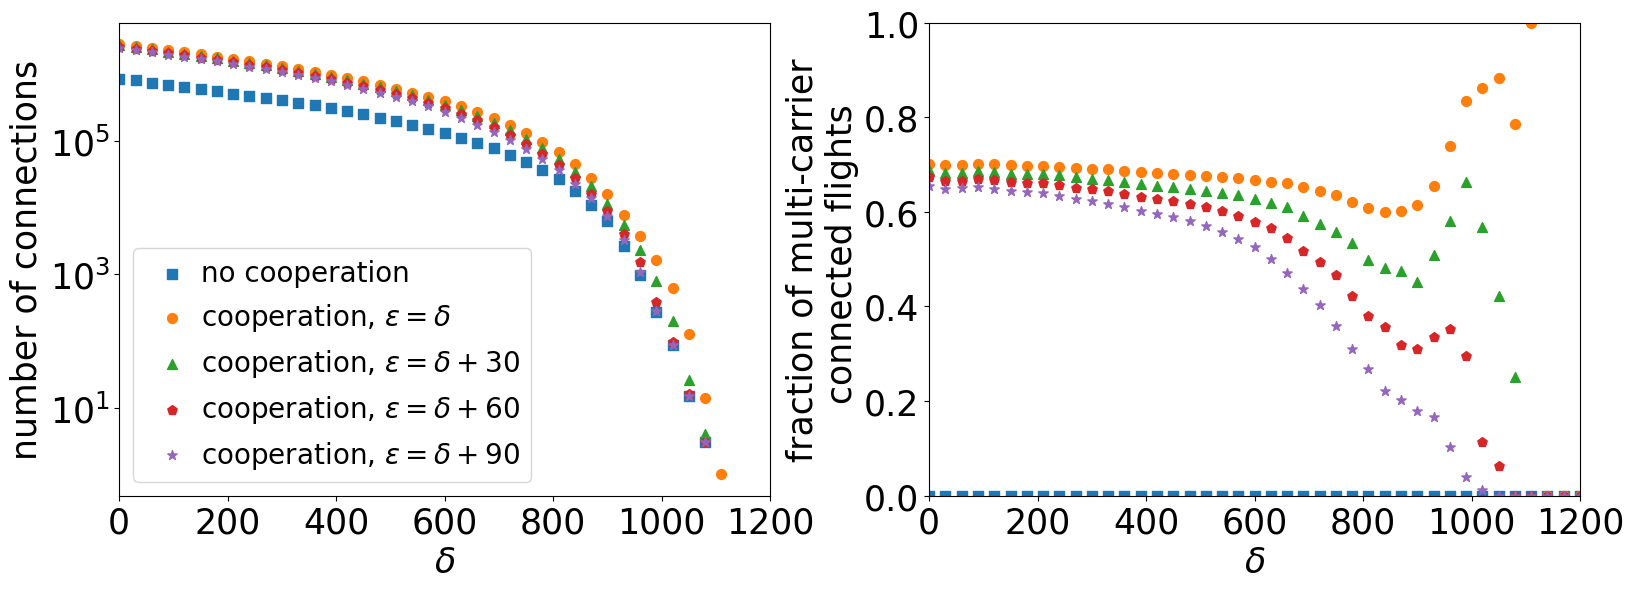

In [15]:
style_config = {1: {"marker": "s", "s": 50, "label": "no cooperation"},
                2: {"marker": "o", "s": 50, "label": r"cooperation, $\epsilon=\delta$"},
                3: {"marker": "^", "s": 50, "label": r"cooperation, $\epsilon=\delta + 30$"},
                4: {"marker": "p", "s": 50, "label": r"cooperation, $\epsilon=\delta + 60$"},
                5: {"marker": "*", "s": 50, "label": r"cooperation, $\epsilon=\delta + 90$"}}

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))


ax[0].scatter(delta_vals, connection_counts[1], 
              marker=style_config[1]["marker"], s=style_config[1]["s"], label=style_config[1]["label"])
ax[0].scatter(delta_vals, connection_counts[2], 
              marker=style_config[2]["marker"], s=style_config[2]["s"], label=style_config[2]["label"])
ax[0].scatter(delta_vals, connection_counts[3], 
              marker=style_config[3]["marker"], s=style_config[3]["s"], label=style_config[3]["label"])
ax[0].scatter(delta_vals, connection_counts[4], 
              marker=style_config[4]["marker"], s=style_config[4]["s"], label=style_config[4]["label"])
ax[0].scatter(delta_vals, connection_counts[5], 
              marker=style_config[5]["marker"], s=style_config[5]["s"], label=style_config[5]["label"])

ax[0].set_xlabel("$\delta$", fontsize=25)
ax[0].set_ylabel("number of connections", fontsize=25)
ax[0].set_yscale('log')
ax[0].set_xlim(0, 1200)
ax[0].tick_params('both', labelsize=25)
ax[0].legend(fontsize=20, handletextpad=0.05)


ax[1].scatter(delta_vals, multi_carrier_connection_fractions[1], 
              marker=style_config[1]["marker"], s=style_config[1]["s"], label=style_config[1]["label"])
ax[1].scatter(delta_vals, multi_carrier_connection_fractions[2], 
              marker=style_config[2]["marker"], s=style_config[2]["s"], label=style_config[2]["label"])
ax[1].scatter(delta_vals, multi_carrier_connection_fractions[3], 
              marker=style_config[3]["marker"], s=style_config[3]["s"], label=style_config[3]["label"])
ax[1].scatter(delta_vals, multi_carrier_connection_fractions[4], 
              marker=style_config[4]["marker"], s=style_config[4]["s"], label=style_config[4]["label"])
ax[1].scatter(delta_vals, multi_carrier_connection_fractions[5], 
              marker=style_config[5]["marker"], s=style_config[5]["s"], label=style_config[5]["label"])

ax[1].set_xlabel("$\delta$", fontsize=25)
ax[1].set_ylabel("fraction of multi-carrier\n connected flights", fontsize=25)
ax[1].tick_params('both', labelsize=25)
ax[1].set_xlim(0, 1200)
ax[1].set_ylim(0, 1.)

plt.tight_layout()
plt.show()

In [ ]:
from pdf2image import convert_from_path
import matplotlib.image as mpimg

panel_a = convert_from_path(os.path.join("../results", "manuscript", "schematic_1a.pdf"))
panel_a[0] = panel_a[0].crop((50, 250, 1400, 1450))

panel_b = convert_from_path(os.path.join("../results", "manuscript", "schematic_1b.pdf"))
panel_b[0] = panel_b[0].crop((150, 500, 950, 1200))

panel_c = convert_from_path(os.path.join("../results", "manuscript", "schematic_1c.pdf"))
panel_c[0] = panel_c[0].crop((150, 550, 2050, 1150))


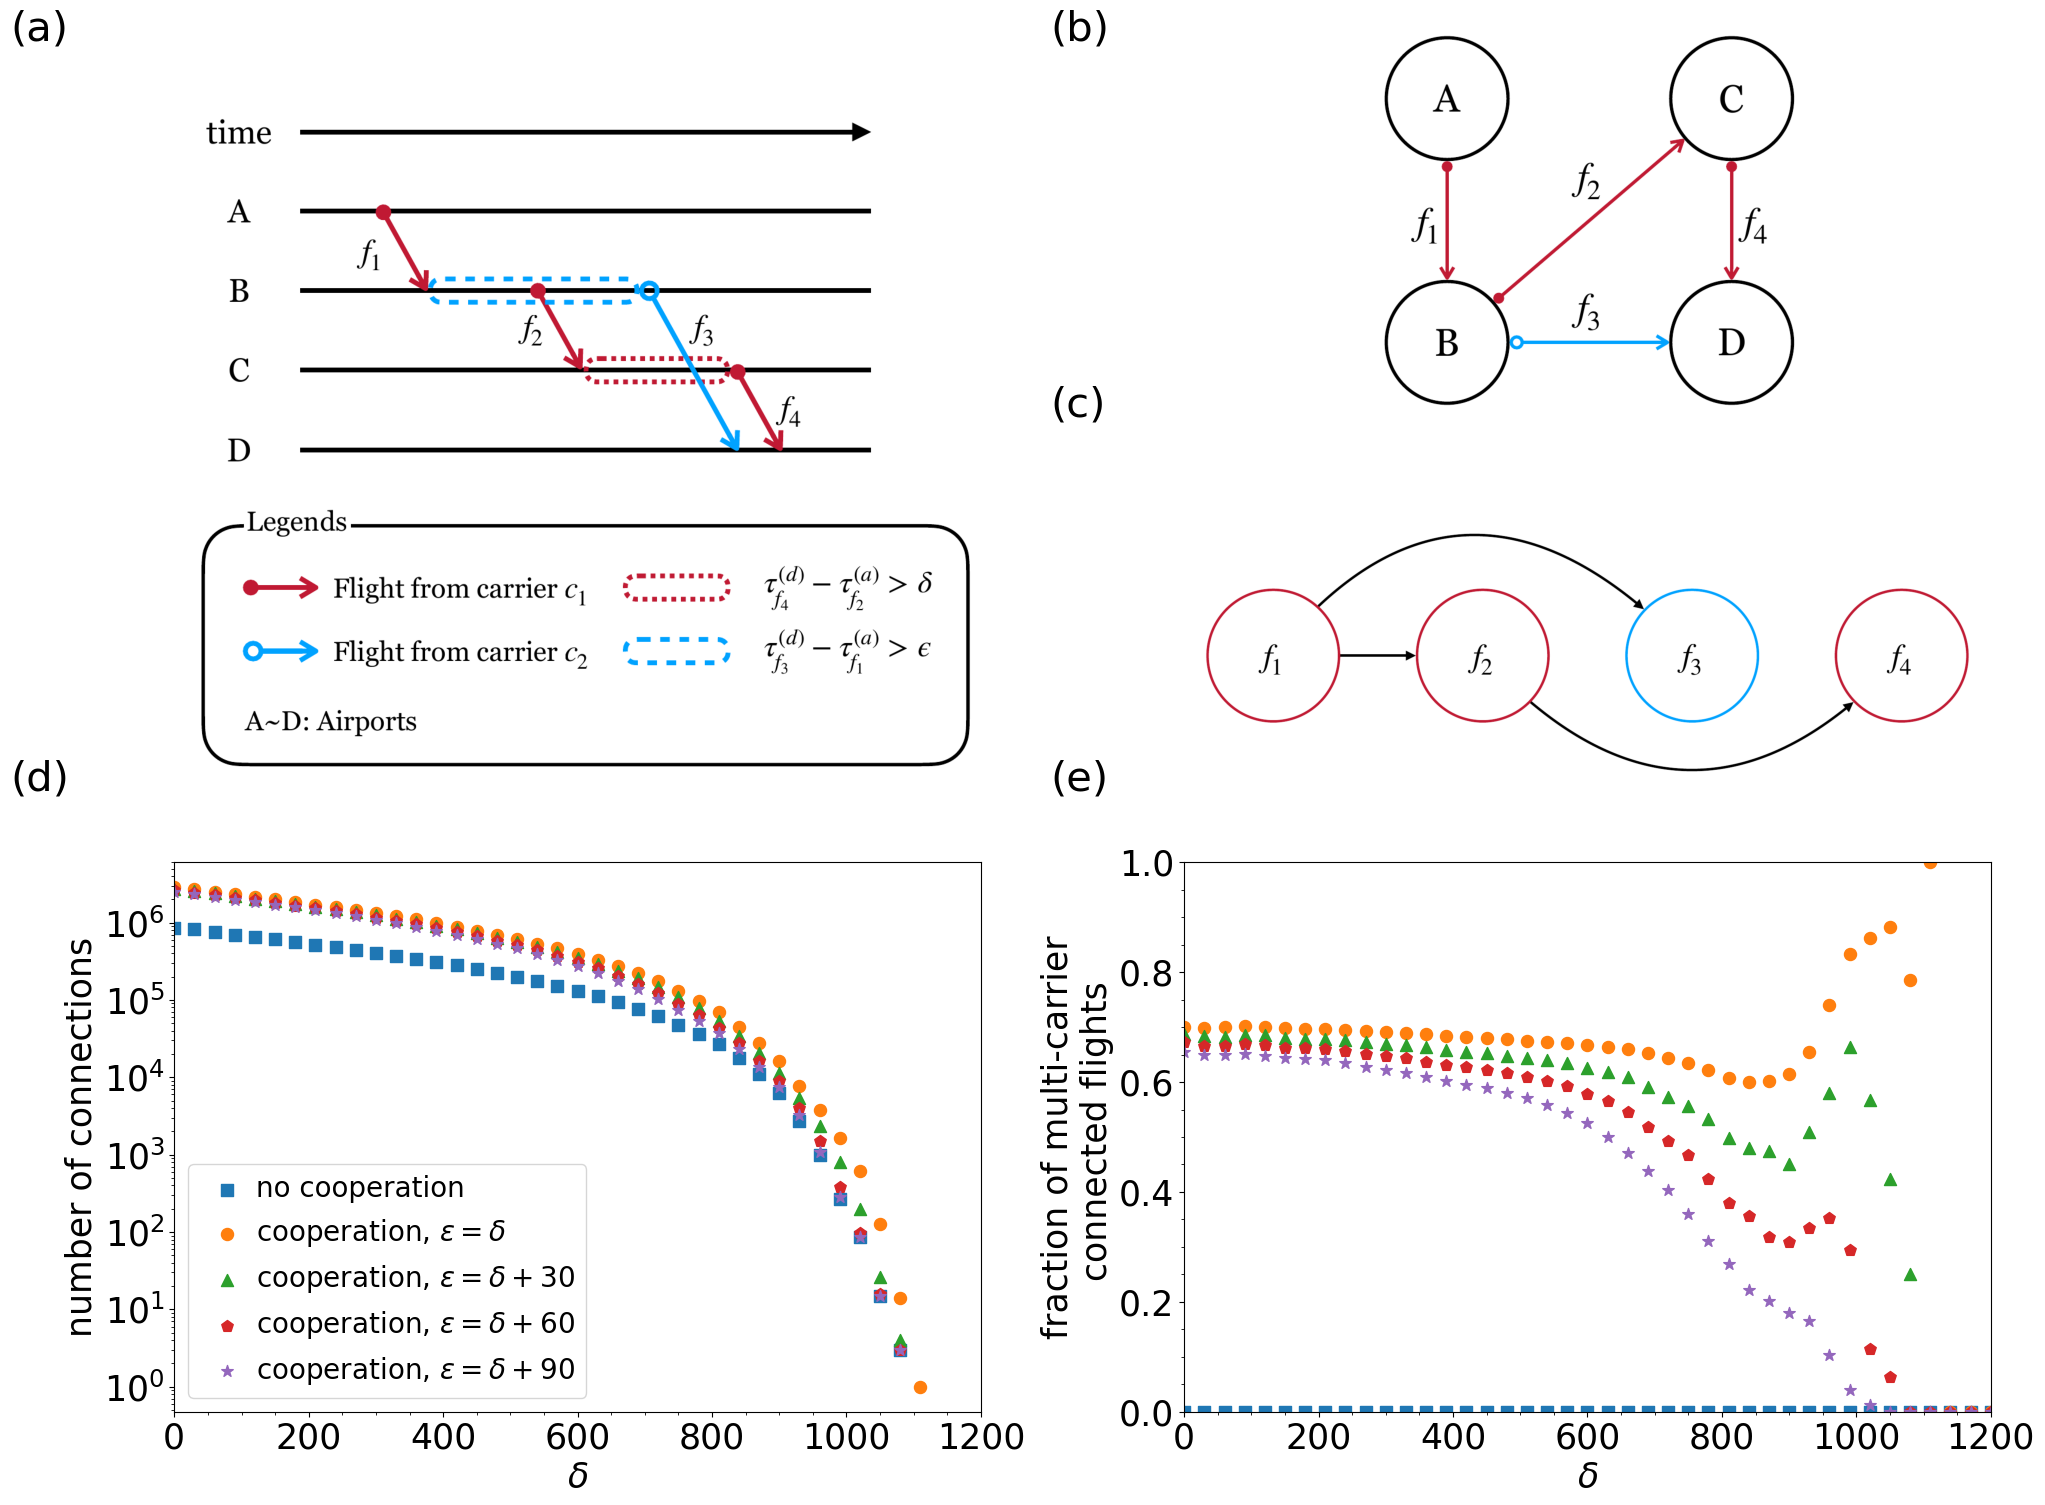

In [124]:
style_config = {1: {"marker": "s", "s": 75, "label": "no cooperation"},
                2: {"marker": "o", "s": 75, "label": r"cooperation, $\epsilon=\delta$"},
                3: {"marker": "^", "s": 75, "label": r"cooperation, $\epsilon=\delta + 30$"},
                4: {"marker": "p", "s": 75, "label": r"cooperation, $\epsilon=\delta + 60$"},
                5: {"marker": "*", "s": 75, "label": r"cooperation, $\epsilon=\delta + 90$"}}


fig = plt.figure(figsize=(20, 15))

# Create a gridspec layout with 2 rows and 2 columns
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 0.8], width_ratios=[1, 1])

# Create a nested gridspec for the top right cell to stack panels B and C
gs_top_right = gs[0, 1].subgridspec(2, 1, height_ratios=[1, 1], hspace=0.1)

# First row - single panel spanning both columns
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(panel_a[0])
ax1.axis('off')

# Second row - two panels
ax2 = fig.add_subplot(gs_top_right[0])
ax2.imshow(panel_b[0]) 
ax2.axis('off')

ax3 = fig.add_subplot(gs_top_right[1])
ax3.imshow(panel_c[0])
ax3.axis('off')

# Third row - two panels
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(delta_vals, connection_counts[1], 
              marker=style_config[1]["marker"], s=style_config[1]["s"], label=style_config[1]["label"])
ax4.scatter(delta_vals, connection_counts[2], 
              marker=style_config[2]["marker"], s=style_config[2]["s"], label=style_config[2]["label"])
ax4.scatter(delta_vals, connection_counts[3], 
              marker=style_config[3]["marker"], s=style_config[3]["s"], label=style_config[3]["label"])
ax4.scatter(delta_vals, connection_counts[4], 
              marker=style_config[4]["marker"], s=style_config[4]["s"], label=style_config[4]["label"])
ax4.scatter(delta_vals, connection_counts[5], 
              marker=style_config[5]["marker"], s=style_config[5]["s"], label=style_config[5]["label"])

ax4.set_xlabel("$\delta$", fontsize=25)
ax4.set_ylabel("number of connections", fontsize=25)
ax4.set_yscale('log')
ax4.set_xlim(0, 1200)
ax4.minorticks_on()
ax4.tick_params('both', labelsize=25)
ax4.legend(fontsize=20, handletextpad=0.05)

ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(delta_vals, multi_carrier_connection_fractions[1], 
              marker=style_config[1]["marker"], s=style_config[1]["s"], label=style_config[1]["label"])
ax5.scatter(delta_vals, multi_carrier_connection_fractions[2], 
              marker=style_config[2]["marker"], s=style_config[2]["s"], label=style_config[2]["label"])
ax5.scatter(delta_vals, multi_carrier_connection_fractions[3], 
              marker=style_config[3]["marker"], s=style_config[3]["s"], label=style_config[3]["label"])
ax5.scatter(delta_vals, multi_carrier_connection_fractions[4], 
              marker=style_config[4]["marker"], s=style_config[4]["s"], label=style_config[4]["label"])
ax5.scatter(delta_vals, multi_carrier_connection_fractions[5], 
              marker=style_config[5]["marker"], s=style_config[5]["s"], label=style_config[5]["label"])

ax5.set_xlabel("$\delta$", fontsize=25)
ax5.set_ylabel("fraction of multi-carrier\n connected flights", fontsize=25)
ax5.tick_params('both', labelsize=25)
ax5.set_xlim(0, 1200)
ax5.set_ylim(0, 1.)
ax5.minorticks_on()



# Adjust the panel labels position and style
label_kwargs = {
    'fontsize': 30,
    'ha': 'left',
    'va': 'top'
}

# ax1.text(-0.1, 1.05, "(a)", transform=ax1.transAxes, **label_kwargs)
# ax2.text(-0.1, 1.05, "(b)", transform=ax2.transAxes, **label_kwargs)
# ax3.text(-0.1, 1.05, "(c)", transform=ax3.transAxes, **label_kwargs)
# ax4.text(-0.2, 1.05, "(d)", transform=ax4.transAxes, **label_kwargs)
# ax5.text(-0.2, 1.05, "(e)", transform=ax5.transAxes, **label_kwargs)

fig.text(-0.02, 1.0, "(a)", **label_kwargs)
fig.text(0.5, 1.0, "(b)", **label_kwargs)
fig.text(0.5, 0.75, "(c)", **label_kwargs)
fig.text(-0.02, 0.5, "(d)", **label_kwargs)
fig.text(0.5, 0.5, "(e)", **label_kwargs)

plt.tight_layout()
plt.savefig(os.path.join("../results", "manuscript", "figure1.pdf"), bbox_inches="tight")
plt.show()


In [68]:
panel_b[0].size

(2200, 1700)